# Optimizing Deep Learning Models with CIFAR-10: Quantization, Pruning, and Distillation

### 1. Import Libraries and Load data

#### 1.1 Import Libaries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.quantization
from torch.utils.data import DataLoader
from torchvision.models import resnet18
import torch.nn.utils.prune as prune
import time
import os

#### 1.2 Load CIFAR-100 dataset

In [2]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [3]:
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

100%|██████████| 170M/170M [00:03<00:00, 48.6MB/s] 


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [4]:
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
testloader = DataLoader(testset, batch_size=64, shuffle=False)

#### 1.3 Load pre-trained ResNet model:

In [5]:
model = resnet18(pretrained=True)
model.fc = nn.Linear(512, 10)  # Adjust for CIFAR-10 classes

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 160MB/s] 


In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [7]:
device

device(type='cuda')

#### 1.4 Training function:

In [8]:
def train(model, trainloader, criterion, optimizer, epochs=5):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss: {running_loss/len(trainloader):.4f}")

#### 1.5 Evalution function:

In [9]:
# Evaluation function (Fixed)
def evaluate(model, testloader, quantized=False):
    model.eval()
    
    # Ensure quantized models run on CPU
    if quantized:
        model.to("cpu")
        model_device = 'cpu'
    else:
        model.to(device)
        model_device = device
    
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(model_device), labels.to(model_device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    return correct / total


#### 1.6 Train the model:

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
train(model, trainloader, criterion, optimizer, epochs=5)

Epoch 1, Loss: 0.5584
Epoch 2, Loss: 0.3213
Epoch 3, Loss: 0.2217
Epoch 4, Loss: 0.1621
Epoch 5, Loss: 0.1276


In [11]:
acc_before = evaluate(model, testloader)
print(f"Accuracy before optimization: {acc_before:.4f}")

Accuracy before optimization: 0.8879


### 2. Optimization Techniques:

#### 2.1 Quantization:

In [12]:
def quantize_model(model):
    model.to("cpu")
    model.eval()
    
    # Dynamic quantization (only supports Linear and LSTM layers)
    quantized_model = torch.quantization.quantize_dynamic(
        model, 
        {nn.Linear},  # Specify which layers to quantize
        dtype=torch.qint8
    )
    
    return quantized_model


In [13]:
quantized_model = quantize_model(model)

In [14]:
acc_quantized = evaluate(quantized_model, testloader, True)
print(f"Accuracy after quantization: {acc_quantized:.4f}")

Accuracy after quantization: 0.8878


#### 2.2 Pruning:

In [15]:
# Pruning
def prune_model(model, amount=0.2):
    model = model.to("cpu")  # Move to CPU for pruning
    for name, module in model.named_modules():
        if isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear):
            prune.l1_unstructured(module, name='weight', amount=amount)
    model = model.to(device)  # Move back to CUDA if available
    return model

pruned_model = prune_model(model)
train(pruned_model, trainloader, criterion, optimizer, epochs=3)

Epoch 1, Loss: 0.0666
Epoch 2, Loss: 0.0682
Epoch 3, Loss: 0.0559


In [16]:
acc_pruned = evaluate(pruned_model, testloader)
print(f"Accuracy after pruning: {acc_pruned:.4f}")

Accuracy after pruning: 0.9068


#### 2.3 Distillation:

In [17]:
class StudentNet(nn.Module):
    def __init__(self):
        super(StudentNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * 56 * 56, 10)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2, 2)
    
    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return x

student_model = StudentNet().to(device)

In [18]:
def distill(teacher, student, trainloader, optimizer, epochs=5, alpha=0.5, temperature=3):
    teacher.eval()
    student.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            
            teacher_outputs = teacher(images).detach()
            student_outputs = student(images)
            
            loss_hard = criterion(student_outputs, labels)
            loss_soft = nn.KLDivLoss()(nn.functional.log_softmax(student_outputs/temperature, dim=1),
                                       nn.functional.softmax(teacher_outputs/temperature, dim=1))
            loss = alpha * loss_hard + (1 - alpha) * loss_soft
            
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss: {running_loss/len(trainloader):.4f}")

In [19]:
distill_optimizer = optim.Adam(student_model.parameters(), lr=0.001)
distill(model, student_model, trainloader, distill_optimizer, epochs=5)
acc_student = evaluate(student_model, testloader)
print(f"Student model accuracy: {acc_student:.4f}")

/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3369: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Epoch 1, Loss: 0.8649
Epoch 2, Loss: 0.7045
Epoch 3, Loss: 0.6456
Epoch 4, Loss: 0.6037
Epoch 5, Loss: 0.5684
Student model accuracy: 0.5576


### 3. Evaluation:

#### 3.1 Model size before and after optimization:

In [20]:
def get_model_size(model):
    torch.save(model.state_dict(), "temp.p")
    size = os.path.getsize("temp.p") / 1e6  # Convert bytes to MB
    os.remove("temp.p")
    return size


In [21]:
sizes = {
    "Original": get_model_size(model),
    "Quantized": get_model_size(quantized_model),
    "Pruned": get_model_size(pruned_model),
    "Student": get_model_size(student_model)
}

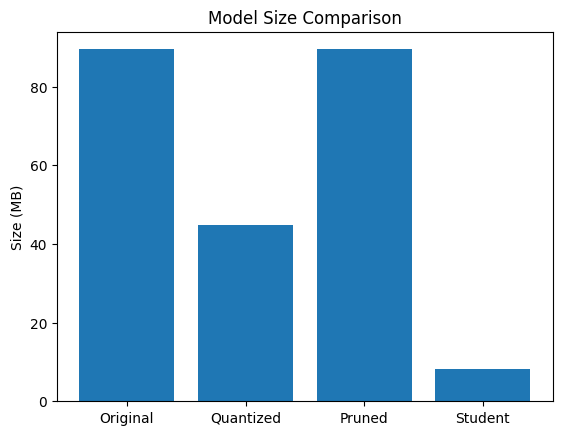

In [22]:
# Visualizing results
labels, sizes = zip(*sizes.items())
plt.bar(labels, sizes)
plt.ylabel("Size (MB)")
plt.title("Model Size Comparison")
plt.show()

In [23]:
print(f"Original Accuracy: {acc_before:.4f}")
print(f"Quantized Accuracy: {acc_quantized:.4f}")
print(f"Pruned Accuracy: {acc_pruned:.4f}")
print(f"Student Accuracy: {acc_student:.4f}")

Original Accuracy: 0.8879
Quantized Accuracy: 0.8878
Pruned Accuracy: 0.9068
Student Accuracy: 0.5576


In [24]:
accuracies = {
    "Original": acc_before,
    "Quantized": acc_quantized,
    "Pruned": acc_pruned,
    "Student": acc_student
}

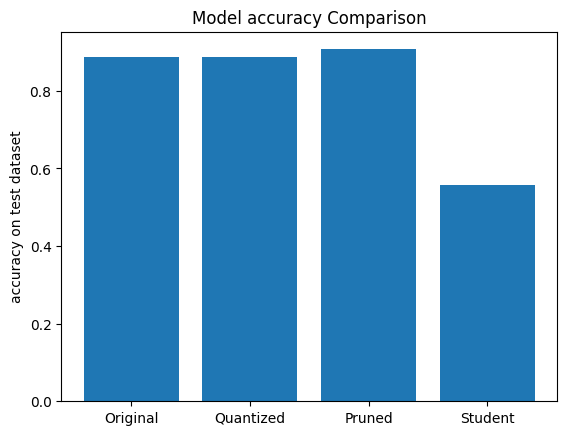

In [25]:
# Visualizing results
labels, sizes = zip(*accuracies.items())
plt.bar(labels, sizes)
plt.ylabel("accuracy on test dataset")
plt.title("Model accuracy Comparison")
plt.show()

The Quantized model have the same accuarcy as the original with half of size.